# Analyse de sentiments avec BERT




BERT est introduit dans [ce papier](https://arxiv.org/abs/1810.04805) et est un acronyme pour Bidirectional Encoder Representations from Transformers. 

Ce modèle est : 

- Bidirectionel - to understand the text  you're looking you'll have to look back (at the previous words) and forward (at the next words)
- Utilise les transformers - présentés dans le papier The [Attention Is All You Need](https://arxiv.org/abs/1706.03762)
- Il est pré-entrainé en utilisant des word embeddings qui encodent les mots basés sur leur contexte.


## Setup

On installe [la librairie Transformers](https://huggingface.co/transformers/) de Hugging Face:

In [1]:
!pip install -q -U watermark

In [2]:
!pip install -qq transformers

In [3]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torchtext import data
from torchtext import datasets
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

## Préparer les données

La préparation des données pour BERT est différente que pour nos modèles précédents. Il faut : 

- Ajouter des tokens spécaux pour séparer les commentaires et faire la classification.
- Passer des séquences de taille constante (padding)
- Créer des array de 0 (pour les tokens pad) et de 1 (vrai token) appelés attention mask.

In [4]:
my_path = 'data/'
train = pd.read_csv(my_path + "train.csv") 
validation = pd.read_csv(my_path + "valid.csv") 
test = pd.read_csv(my_path + "test.csv")

In [5]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased' # on utilise le modèle qui ne prend pas en compte les majuscules

In [6]:
import transformers
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [7]:
from torch import nn, optim

In [8]:
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import random

In [9]:
class_names = ['negative',  'positive']

On crée une classe qui pré-traite nos données.

In [10]:
class GPReviewDataset(Dataset):

    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
  
    def __len__(self):
        return len(self.reviews)
  
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]
        # cette méthode permet d'ajouter les tokens spéciaux de début, de fin 
        # tokenise les séquence, les transforme en index
        # réalise le padding et retourne le masque d'attention
        encoding = self.tokenizer.encode_plus(
          review,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )

        return {
          'review_text': review,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target, dtype=torch.long)
        }

In [11]:
df_train = train
df_val = validation
df_test = test

In [12]:
df_train.shape, df_val.shape, df_test.shape

((40000, 2), (5000, 2), (5000, 2))

In [13]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.text.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
      )

    return DataLoader(
        ds,
        batch_size=batch_size,
      )

In [14]:
BATCH_SIZE = 16
MAX_LEN = 500

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [15]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [16]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 500])
torch.Size([16, 500])
torch.Size([16])


## Construction du modèle

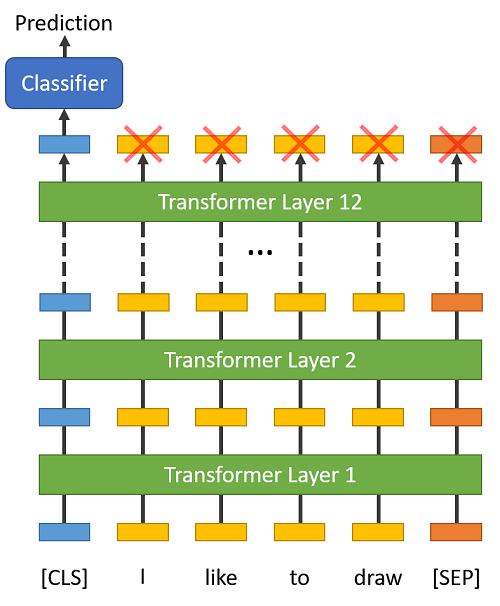

In [17]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [18]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.dropout = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
        input_ids=input_ids,
        attention_mask=attention_mask
        )
        output = self.dropout(pooled_output)
        return self.out(output)

In [19]:
n_classes = 2
model = SentimentClassifier(n_classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'
model = model.to(device)

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Le modèle a {count_parameters(model):,} paramètres à entraîner')

Le modèle a 109,483,778 paramètres à entraîner


### Entraînement

Pour reproduire l'entraînement du papier BERT, on utilise l'optimiseur [AdamW](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#adamw). 

Pour les hyperparamètres on utilise ceux décrits par les auteurs de BERT :  

- Batch size: 16, 32
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

In [21]:
EPOCHS = 2
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [22]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
    model = model.train()
    losses = []
    correct_predictions = 0
  
    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)

        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [23]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
              )
            _, preds = torch.max(outputs, dim=1)

            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time

history = defaultdict(list)
best_accuracy = 0
EPOCHS = 2
for epoch in range(EPOCHS):

    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,    
        loss_fn, 
        optimizer, 
        device, 
    scheduler, 
    len(df_train)
  )

    print(f'Train loss {train_loss} accuracy {train_acc}')

    val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
    )

    print(f'Val   loss {val_loss} accuracy {val_acc}')
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/2
----------


## Test


In [ ]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
  
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:

            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            outputs = model(
                        input_ids=input_ids,
                        attention_mask=attention_mask
                          )
            _, preds = torch.max(outputs, dim=1)

            probs = F.softmax(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(probs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

### Inférence


In [ ]:
review_text = "this film is not good"

In [ ]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [ ]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

## Références

- [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805)
- https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/